In [1]:
import numpy as np
import pandas as pd
import copy
import galsim
import piff
from piff.star import Star, StarFit, StarData
from donutlib.makedonut import makedonut

# this needs to go after piff, since it resets matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
print(piff.__version__)
print(galsim.__version__)

0.4
2.3


# Make donuts with donutlib and PIFF, and compare shapes

In [3]:
def donut_calc(zarray, r0):
    donut_zarray = [0,0,0]+zarray
    donutDict = {'writeToFits':False,
                 'iTelescope':0,    # for DECam
                 'nZernikeTerms':37,
                 'nbin':512,
                 'nPixels':64,
                 'pixelOverSample':8,
                 'scaleFactor':1.0,
                 'rzero':r0,
                 'nEle':1.0e0, 
                 'background':0., 
                 'randomFlag':False,
                 'randomSeed':1234567890, 
                 'xDECam': 118.,'yDECam' :128. , #in sensor N24
                 'ZernikeArray':donut_zarray}
    return makedonut(**donutDict).make()

In [4]:
# Piff Configuration
# This function creates the config for a psf

def return_config():
    return {
        'type': 'OptAtmo',
        'optical_psf_kwargs': {
            'template': 'des',  # was 'des_vonkarman' not available now
            'pad_factor' : 8.0,   # must include and set to 8 for donuts
        },
        'reference_wavefront': None,
        'n_optfit_stars': 0,
        'fov_radius': 4500.,
        'jmax_pupil': 21,  # was 37
        'jmax_focal': 1,   # was 3
        'min_optfit_snr': 0,
        'higher_order_reference_wavefront_file': None,
        'init_with_rf' : False,
        'random_forest_shapes_model_pickles_location': None,
        'optatmo_psf_kwargs':
            {
                'size': 1.0,
                'g1': 0.0,
                'g2': 0.0,
                'L0': 25., 
                'fix_size': False,
                'fix_g1': False,
                'fix_g2': False,
                'fix_L0': False,
                'fix_zPupil004_zFocal001': False,  
                'fix_zPupil005_zFocal001': False,  
                'fix_zPupil006_zFocal001': False,   
                'fix_zPupil007_zFocal001': False,   
                'fix_zPupil008_zFocal001': False,  
                'fix_zPupil009_zFocal001': False,    
                'fix_zPupil010_zFocal001': False,  
                'fix_zPupil011_zFocal001': False,  
                'fix_zPupil012_zFocal001': False,    
                'fix_zPupil013_zFocal001': False,  
                'fix_zPupil014_zFocal001': False,  
                'fix_zPupil015_zFocal001': False,  
                'fix_zPupil016_zFocal001': False,  
                'fix_zPupil017_zFocal001': False,  
                'fix_zPupil018_zFocal001': False,  
                'fix_zPupil019_zFocal001': False,  
                'fix_zPupil020_zFocal001': False,  
                'fix_zPupil021_zFocal001': False,  
                'fix_zPupil022_zFocal001': False
            },
        'atmo_interp': 'none',
        'reference_wavefront_zernikes_list': list(range(4,12)),
        'higher_order_reference_wavefront_zernikes_list': list(range(12,22+1)),
        'atmosphere_model': 'vonkarman', 
    }


In [5]:
# This function creates a blank star given a chipnum and a location.
def make_blank_star(x, y, chipnum, properties={}, **kwargs):
    decaminfo = piff.des.DECamInfo()    
    wcs = decaminfo.get_nominal_wcs(chipnum)
    properties_in = {'chipnum': chipnum}
    properties_in.update(properties)
    star = piff.Star.makeTarget(x=x, y=y, wcs=wcs, stamp_size=64, properties=properties_in, **kwargs)
    return star

In [6]:
# print out the WCS
decaminfo = piff.des.DECamInfo()    
wcs = decaminfo.get_nominal_wcs(10)
print(wcs)

# this is a transpose and a flip!

galsim.AffineTransform(0.0, -0.26, -0.26, 0.0, origin=galsim.PositionD(x=0.0, y=0.0), world_origin=galsim.PositionD(x=532.35, y=2317.614))


In [7]:
# make stars from Piff OptAtmo

config = return_config()
psf = piff.PSF.process(config)
#psf._force_vk_stepk = 3.8694890418282872 * 0.8

chipnum = 10
icen = 500
jcen = 500
blank_star = make_blank_star(icen,jcen,chipnum)

# fit_params is: atmo_size, atmo_g1, atmo_g2, L0, opt_size, opt_g1, opt_g2, z4, z5, z6, z7, z8, z9, z10, z11 to z22
fit_params = np.array([0.0,0.0,0.0,25.,0.1,0.0,0.0,
                   12.,0.5,0.0,0.0,0.5,0.0,0.0,
                   0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
prof = psf.getProfile(copy.deepcopy(blank_star),fit_params)  #a Profile is a GalSim object that knows *how* to be drawn, here it is the convoluation of OpticalPSF and VonKarman
noiseless_star = psf.drawProfile(blank_star, prof, fit_params)   # this draws the Profile into a Star object
noiseless_image = noiseless_star.image

# this dumps out the constructor for the PSF profile used - can remake it below modified to make Donuts
prof

galsim.Convolution([galsim.OpticalPSF(lam=700.0, diam=4.274419, aper=galsim.Aperture(diam=4.274419, obscuration=0.41957067187064395, nstruts=4, strut_thick=0.009117992518703244, strut_angle=coord.Angle(0.7853981633974483, coord.radians), pupil_plane_scale=None, pupil_plane_size=None, oversampling=1.0, pad_factor=8.0, gsparams=galsim.GSParams(32,8192,0.02,5.0,0.01,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)), aberrations=[0.0,0.0,0.0,0.0,12.0,0.5,0.0,0.0,0.5], gsparams=galsim.GSParams(32,8192,0.02,5.0,0.01,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)), galsim.Transformation(galsim.VonKarman(lam=700.0, r0=1.0, L0=25.0, flux=1.0, gsparams=galsim.GSParams(32,8192,0.02,5.0,0.01,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)), jac=[[1.0, 0.0], [0.0, 1.0]], offset=galsim.PositionD(x=0.0, y=0.0), flux_ratio=1.0, gsparams=galsim.GSParams(32,8192,0.02,5.0,0.01,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05), propagate_gsparams=True)], real_space=False, gsparams=galsim.GSParams(32,8192,0.02,5.0,0

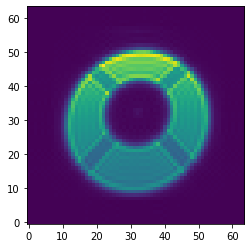

In [8]:
f,ax = plt.subplots(1,1)
ax.imshow(noiseless_image.array,origin='lower',interpolation='None')

# Study Galsim PSFs code to make Donuts

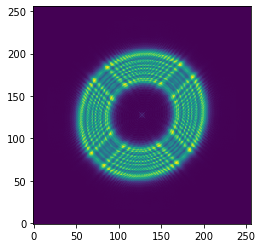

In [9]:
# using just OpticalPsf
import coord

z4 = 10.0

aopsf = galsim.OpticalPSF(lam=700.0, diam=4.274419, 
                        aper=galsim.Aperture(diam=4.274419, obscuration=0.42, nstruts=4, strut_thick=0.01, strut_angle=coord.Angle(0.7853981633974483, coord.radians),oversampling=1.,pad_factor=2.), 
                        pupil_plane_scale=None, pupil_plane_size=None, oversampling=1.0, pad_factor=1.0, 
                        aberrations=[0.0,0.0,0.0,0.0,z4,0.5,0.0])
                                     
image = aopsf.drawImage(method='auto', nx=256,ny=256)
f,ax = plt.subplots(1,1)
ax.imshow(image.array,origin='lower',interpolation='None')

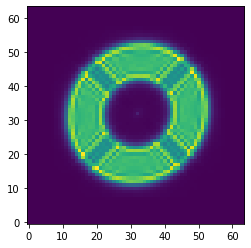

In [10]:
# using OpticalPsf, drawn onto a blank star with wcs


z4 = 12.0

chipnum = 10
icen = 500
jcen = 500
blank_star = make_blank_star(icen,jcen,chipnum)

aopsf = galsim.OpticalPSF(lam=700.0, diam=4.274419, 
                        aper=galsim.Aperture(diam=4.274419, obscuration=0.42, nstruts=4, strut_thick=0.01, strut_angle=coord.Angle(0.7853981633974483, coord.radians),oversampling=1.,pad_factor=2.), 
                        pupil_plane_scale=None, pupil_plane_size=None, oversampling=1.0, pad_factor=1.0, 
                        aberrations=[0.0,0.0,0.0,0.0,z4,0.5,0.0])
                                                                          
                        
image, weight, image_pos = blank_star.data.getImage()
image_copy = image.copy()
aopsf.drawImage(image_copy, method='auto', center=blank_star.image_pos)

f,ax = plt.subplots(1,1)
ax.imshow(image_copy.array,origin='lower',interpolation='None')

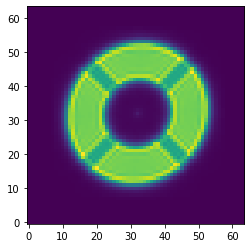

In [11]:
# using OpticalPsf convolved with VonKarman, drawn onto a blank star with wcs

z4 = 12.0

chipnum = 10
icen = 500
jcen = 500
blank_star = make_blank_star(icen,jcen,chipnum)

aopsf = galsim.Convolve(galsim.OpticalPSF(lam=700, diam=4.274419, aberrations=[0.0,0.0,0.0,0.0,z4,0.5,0.0],
                                  aper=galsim.Aperture(diam=4.274419,obscuration=0.42, nstruts=4, strut_thick=0.01, strut_angle=coord.Angle(0.7853981633974483, coord.radians),oversampling=1.,pad_factor=2.)), 
                galsim.VonKarman(lam=700.0, r0=0.5, L0=25.0))
                                                                          
                        
image, weight, image_pos = blank_star.data.getImage()
image_copy = image.copy()
aopsf.drawImage(image_copy, method='auto', center=blank_star.image_pos)

f,ax = plt.subplots(1,1)
ax.imshow(image_copy.array,origin='lower',interpolation='None')

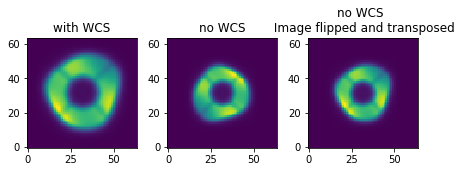

In [18]:
# using OpticalPsf convolved with a sheared VonKarman, drawn onto a blank star with wcs


chipnum = 10
icen = 500
jcen = 500
blank_star = make_blank_star(icen,jcen,chipnum)

# why do I need to scale the zernikes by 5 here, compared to below? because there are also higher order Zernikes present!
#z4,z5,z6,z7,z8,z9,z10,z11,z12,z13,z14,z15 = [12.00, 5*0.14, 5*0.01, 5*-0.06, 5*0.01, 5*-0.10, 5*0.02,0.0,0.0,0.0,0.0,0.0]

z4,z5,z6,z7,z8,z9,z10,z11,z12,z13,z14,z15,z16,z17,z18,z19,z20,z21 = [12.0, 0.143, 0.007, -0.057, 0.006, -0.104, 0.015, -0.005, 0.045, 0.055, -0.022, -0.016, -0.063, -0.039, 0.096, -0.081, -0.090, 0.054]
pad_factor = 8.0
r0 = 0.14

aopsf = galsim.Convolution([galsim.OpticalPSF(lam=700.0, diam=4.274419, 
                                              aper=galsim.Aperture(diam=4.274419, obscuration=0.41957067187064395, nstruts=4, strut_thick=0.009117992518703244, 
                                                                   strut_angle=coord.Angle(0.7853981633974483, coord.radians), 
                                                                   pupil_plane_scale=None, pupil_plane_size=None, oversampling=1.0, pad_factor=8.0, 
                                                                   gsparams=galsim.GSParams(32,8192,0.02,5.0,0.01,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)), 
                                              aberrations=[0.0,0.0,0.0,0.0,z4,z5,z6,z7,z8,z9,z10,z11,z12,z13,z14,z15,z16,z17,z18,z19,z20,z21], gsparams=galsim.GSParams(32,8192,0.02,5.0,0.01,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)), 
                            galsim.Transformation(galsim.VonKarman(lam=700.0, r0=r0, L0=25.0, flux=1.0, gsparams=galsim.GSParams(32,8192,0.02,5.0,0.01,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)), 
                                                  jac=[[1.0, 0.0], [0.0, 1.0]], offset=galsim.PositionD(x=0.0, y=0.0), flux_ratio=1.0, 
                                                  gsparams=galsim.GSParams(32,8192,0.02,5.0,0.01,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05), propagate_gsparams=True)], 
                           real_space=False, gsparams=galsim.GSParams(32,8192,0.02,5.0,0.01,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05), propagate_gsparams=True)
                        
image, weight, image_pos = blank_star.data.getImage()
image_copy = image.copy()
aopsf.drawImage(image_copy, method='auto', center=blank_star.image_pos)

image_nowcs = aopsf.drawImage(method='auto', nx=64,ny=64)

f,ax = plt.subplots(1,3)
ax[0].imshow(image_copy.array,origin='lower',interpolation='None')
ax[0].set_title("with WCS")
ax[1].imshow(image_nowcs.array,origin='lower',interpolation='None')
ax[1].set_title("no WCS")
ax[2].imshow(np.transpose(np.flip(image_nowcs.array)),origin='lower',interpolation='None')
ax[2].set_title("no WCS \n Image flipped and transposed")
f.tight_layout()

# Use Piff/OptAtmo method to make Donuts and compare with Donutlib

In [13]:
# make a method to draw with Piff OptAtmo

def piff_calc(zarray, r0):
    
    chipnum = 10
    icen = 500
    jcen = 500
    blank_star = make_blank_star(icen,jcen,chipnum)

    zarray_pad = [0.,0.,0.,0.]+zarray 
    pad_factor = 8.0
    r0 = 0.14

    # this is the galsim PSF used in PIFF OptAtmo
    aopsf = galsim.Convolution([galsim.OpticalPSF(lam=700.0, diam=4.274419, 
                                              aper=galsim.Aperture(diam=4.274419, obscuration=0.41957067187064395, nstruts=4, strut_thick=0.009117992518703244, 
                                                                   strut_angle=coord.Angle(0.7853981633974483, coord.radians), 
                                                                   pupil_plane_scale=None, pupil_plane_size=None, oversampling=1.0, pad_factor=pad_factor, 
                                                                   gsparams=galsim.GSParams(32,8192,0.02,5.0,0.01,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)), 
                                              aberrations=zarray_pad, gsparams=galsim.GSParams(32,8192,0.02,5.0,0.01,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)), 
                            galsim.Transformation(galsim.VonKarman(lam=700.0, r0=r0, L0=25.0, flux=1.0, gsparams=galsim.GSParams(32,8192,0.02,5.0,0.01,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)), 
                                                  jac=[[1.0, 0.0], [0.0, 1.0]], offset=galsim.PositionD(x=0.0, y=0.0), flux_ratio=1.0, 
                                                  gsparams=galsim.GSParams(32,8192,0.02,5.0,0.01,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05), propagate_gsparams=True)], 
                           real_space=False, gsparams=galsim.GSParams(32,8192,0.02,5.0,0.01,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05), propagate_gsparams=True)
                        
    # and here is the method Piff OptAtmo uses to make stars/donuts
    image, weight, image_pos = blank_star.data.getImage()
    image_copy = image.copy()
    aopsf.drawImage(image_copy, method='auto', center=blank_star.image_pos)
    
    return image_copy

In [14]:
# this transform was derived from 
#$ x = -v $
#$ y = -u $
#$ theta_val = -phi - pi/2$

# fp = donutlib values
# sky = piff values

def transform_zernike_minus(a_fp):
    a_sky = np.empty((18,), float)
 
    # from theta_val = -phi - pi/2   
    a_sky[4-4] = a_fp[4-4]
    a_sky[5-4] = a_fp[5-4]
    a_sky[6-4] = -a_fp[6-4]
    a_sky[7-4] = -a_fp[8-4]
    a_sky[8-4] = -a_fp[7-4]
    a_sky[9-4] = a_fp[10-4]
    a_sky[10-4] = a_fp[9-4]
    a_sky[11-4] = a_fp[11-4]
    a_sky[12-4] = -a_fp[12-4]
    a_sky[13-4] = a_fp[13-4]
    a_sky[14-4] = a_fp[14-4]
    a_sky[15-4] = -a_fp[15-4]
    a_sky[16-4] = -a_fp[17-4]
    a_sky[17-4] = -a_fp[16-4]
    a_sky[18-4] = a_fp[19-4]
    a_sky[19-4] = a_fp[18-4]
    a_sky[20-4] = -a_fp[21-4]
    a_sky[21-4] = -a_fp[20-4]
        
    return list(a_sky)    

In [15]:
# this transform was derived from 
#$ x = v $
#$ y = u $
#$ theta_val = -phi + pi/2$

# fp = donutlib values
# sky = piff values

def transform_zernike_plus(a_fp):
    a_sky = np.empty((18,), float)
 
    # from theta_val = -phi + pi/2   
    
    a_sky[4-4] = a_fp[4-4]
    a_sky[5-4] = a_fp[5-4]
    a_sky[6-4] = -a_fp[6-4]
    a_sky[7-4] = a_fp[8-4]
    a_sky[8-4] = a_fp[7-4]
    a_sky[9-4] = -a_fp[10-4]
    a_sky[10-4] = -a_fp[9-4]
    a_sky[11-4] = a_fp[11-4]
    a_sky[12-4] = -a_fp[12-4]
    a_sky[13-4] = a_fp[13-4]
    a_sky[14-4] = a_fp[14-4]
    a_sky[15-4] = -a_fp[15-4]
    a_sky[16-4] = a_fp[17-4]
    a_sky[17-4] = a_fp[16-4]
    a_sky[18-4] = -a_fp[19-4]
    a_sky[19-4] = -a_fp[18-4]
    a_sky[20-4] = a_fp[21-4]
    a_sky[21-4] = a_fp[20-4]
        
    return list(a_sky)    

12.00, 0.13, -0.25, 0.04, 0.14, -0.19, 0.01, 0.02, -0.08, -0.10, -0.02, -0.03, -0.05, 0.20, 0.05, 0.10, 0.07, 0.00
12.00, 0.20, -0.07, -0.04, -0.14, -0.12, 0.01, -0.20, 0.08, 0.02, 0.11, -0.28, 0.05, 0.01, -0.09, -0.23, -0.01, -0.04
12.00, 0.14, 0.01, -0.06, 0.01, -0.10, 0.02, -0.01, 0.05, 0.06, -0.02, -0.02, -0.06, -0.04, 0.10, -0.08, -0.09, 0.05
12.00, 0.14, 0.04, 0.01, -0.05, 0.12, -0.15, 0.12, 0.16, 0.01, 0.01, -0.09, -0.08, -0.16, 0.06, 0.08, 0.20, -0.08
12.00, -0.04, -0.01, 0.07, -0.14, -0.04, -0.10, 0.01, 0.09, -0.05, 0.08, 0.11, -0.02, 0.15, -0.07, -0.07, 0.11, -0.07
12.00, -0.11, 0.12, 0.02, 0.03, -0.10, 0.05, 0.01, 0.07, -0.18, 0.14, -0.06, -0.02, 0.03, 0.07, 0.03, -0.07, -0.11
12.00, 0.13, 0.06, 0.07, 0.20, 0.08, 0.06, 0.24, 0.08, 0.18, 0.07, 0.05, -0.02, -0.09, 0.13, -0.08, 0.11, -0.07
12.00, 0.12, 0.07, 0.09, -0.11, -0.08, -0.06, 0.17, 0.00, 0.08, -0.13, -0.10, -0.13, -0.07, 0.02, -0.22, 0.00, -0.01
12.00, 0.09, 0.00, -0.13, -0.19, -0.13, -0.09, -0.03, 0.05, -0.15, -0.07, 

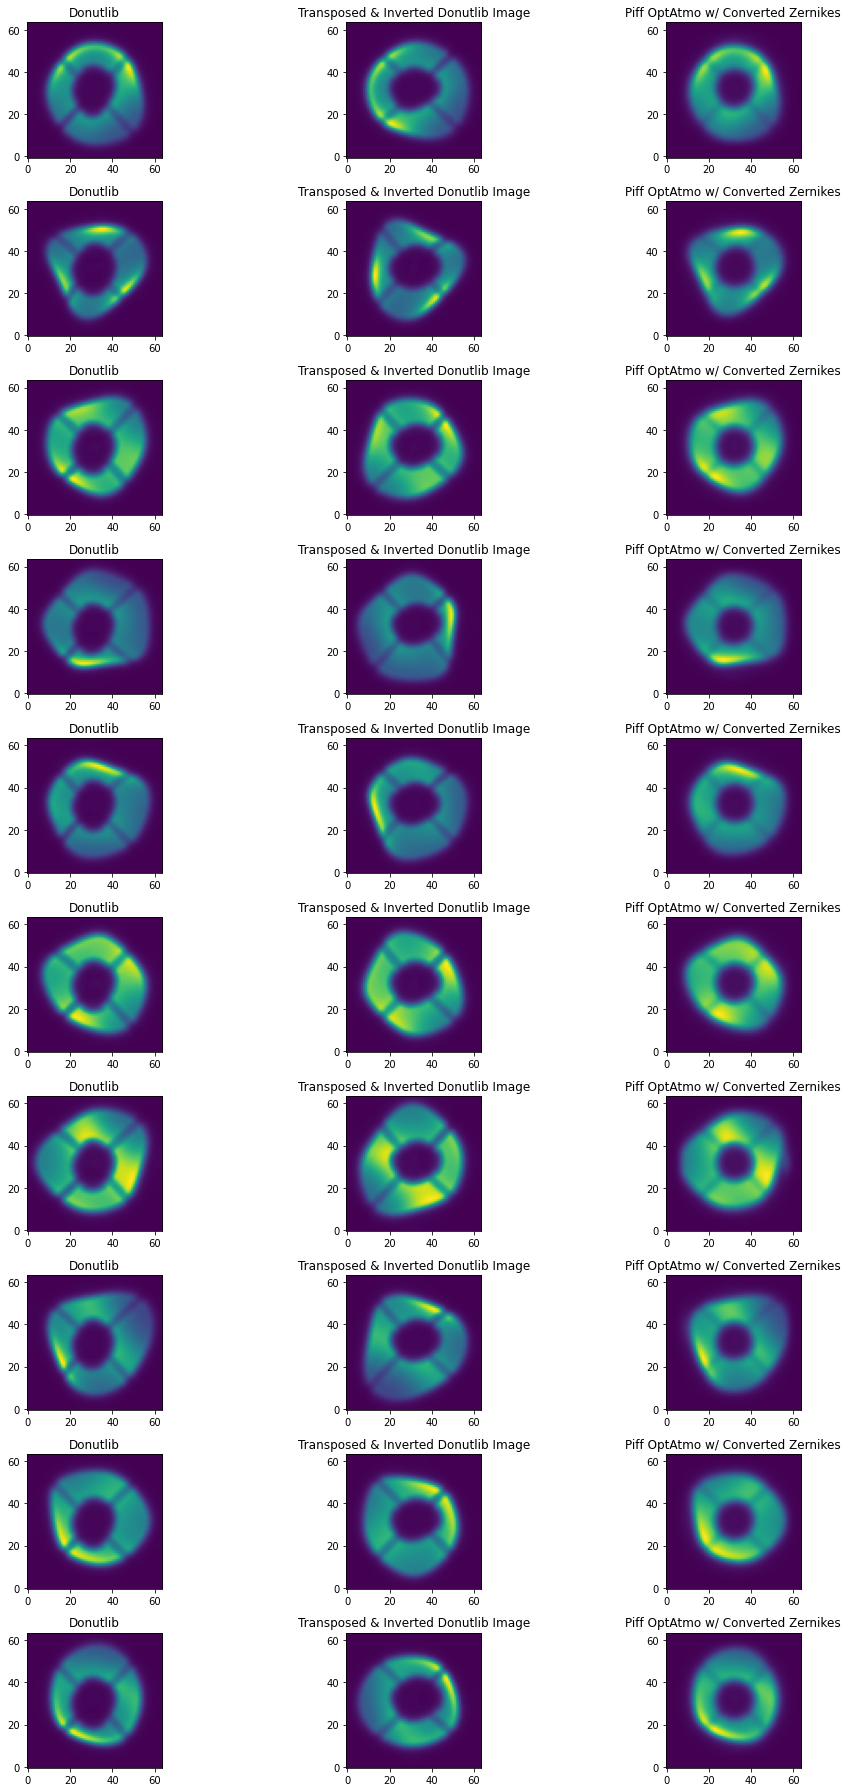

In [19]:
# compare donutlib vs. piff, 
# start with donutlib image which is in (x,y), 
# flip&transpose to make image look as it should in (u,v)
# then compare against Piff image with converted zernikes, also in (u,v)
# 
# the latter two should match!

r0 = 0.2 # Pretty good seeing, corresponds to 0.7 arcsec at 700nm
gd = galsim.GaussianDeviate(12345)
z4 = 12.0
fig, axes = plt.subplots(10, 3, figsize=(15, 25))
for i in range(10):
    # Add Gaussian-distributed aberrations
    zarray_ran = np.empty((17,), float)
    gd.generate(zarray_ran)
    zarray = [z4]+list(0.1*zarray_ran)
    
    print(', '.join(f'{q:.2f}' for q in zarray))
    #print(zarray)
    
    donut_image = donut_calc(zarray, r0)
    piff_image_zconvert = piff_calc(transform_zernike_plus(zarray),r0)
    axes[i, 0].imshow(donut_image,origin='lower')
    axes[i, 1].imshow(np.transpose(np.flip(donut_image)),origin='lower') # should be correct
    axes[i, 2].imshow(piff_image_zconvert.array,origin='lower')

    axes[i, 0].set_title("Donutlib")
    axes[i, 1].set_title("Transposed & Inverted Donutlib Image")
    axes[i, 2].set_title("Piff OptAtmo w/ Converted Zernikes")

fig.tight_layout()
# fig.savefig("comparison.png")

# WHY don't the Transposed & Inverted Donutlib images match the Piff images with Converted Zernikes?
# See below for the results with correct Zernike conversion!!!

# New Analysis of Zernike conversion

See Notebook calculate-Donut-to-GalsimPiff-Zernike-Coordinate-conversion 

In [21]:
# this transform was derived from 
#$ x = -u $
#$ y = -v $
#$ theta_val = phi + pi$

# fp = donutlib values
# sky = piff values

def transform_zernike_new(a_fp):
    a_sky = np.empty((18,), float)
 
    # from theta_val = phi + pi   
 
    a_sky[4-4] = a_fp[4-4]
    a_sky[5-4] = a_fp[5-4]
    a_sky[6-4] = a_fp[6-4]
    a_sky[7-4] = -a_fp[7-4]
    a_sky[8-4] = -a_fp[8-4]
    a_sky[9-4] = -a_fp[9-4]
    a_sky[10-4] = -a_fp[10-4]
    a_sky[11-4] = a_fp[11-4]
    a_sky[12-4] = a_fp[12-4]
    a_sky[13-4] = a_fp[13-4]
    a_sky[14-4] = a_fp[14-4]
    a_sky[15-4] = a_fp[15-4]
    a_sky[16-4] = -a_fp[16-4]
    a_sky[17-4] = -a_fp[17-4]
    a_sky[18-4] = -a_fp[18-4]
    a_sky[19-4] = -a_fp[19-4]
    a_sky[20-4] = -a_fp[20-4]
    a_sky[21-4] = -a_fp[21-4]
        
    return list(a_sky)    

12.00, 0.13, -0.25, 0.04, 0.14, -0.19, 0.01, 0.02, -0.08, -0.10, -0.02, -0.03, -0.05, 0.20, 0.05, 0.10, 0.07, 0.00
12.00, 0.20, -0.07, -0.04, -0.14, -0.12, 0.01, -0.20, 0.08, 0.02, 0.11, -0.28, 0.05, 0.01, -0.09, -0.23, -0.01, -0.04
12.00, 0.14, 0.01, -0.06, 0.01, -0.10, 0.02, -0.01, 0.05, 0.06, -0.02, -0.02, -0.06, -0.04, 0.10, -0.08, -0.09, 0.05
12.00, 0.14, 0.04, 0.01, -0.05, 0.12, -0.15, 0.12, 0.16, 0.01, 0.01, -0.09, -0.08, -0.16, 0.06, 0.08, 0.20, -0.08
12.00, -0.04, -0.01, 0.07, -0.14, -0.04, -0.10, 0.01, 0.09, -0.05, 0.08, 0.11, -0.02, 0.15, -0.07, -0.07, 0.11, -0.07
12.00, -0.11, 0.12, 0.02, 0.03, -0.10, 0.05, 0.01, 0.07, -0.18, 0.14, -0.06, -0.02, 0.03, 0.07, 0.03, -0.07, -0.11
12.00, 0.13, 0.06, 0.07, 0.20, 0.08, 0.06, 0.24, 0.08, 0.18, 0.07, 0.05, -0.02, -0.09, 0.13, -0.08, 0.11, -0.07
12.00, 0.12, 0.07, 0.09, -0.11, -0.08, -0.06, 0.17, 0.00, 0.08, -0.13, -0.10, -0.13, -0.07, 0.02, -0.22, 0.00, -0.01
12.00, 0.09, 0.00, -0.13, -0.19, -0.13, -0.09, -0.03, 0.05, -0.15, -0.07, 

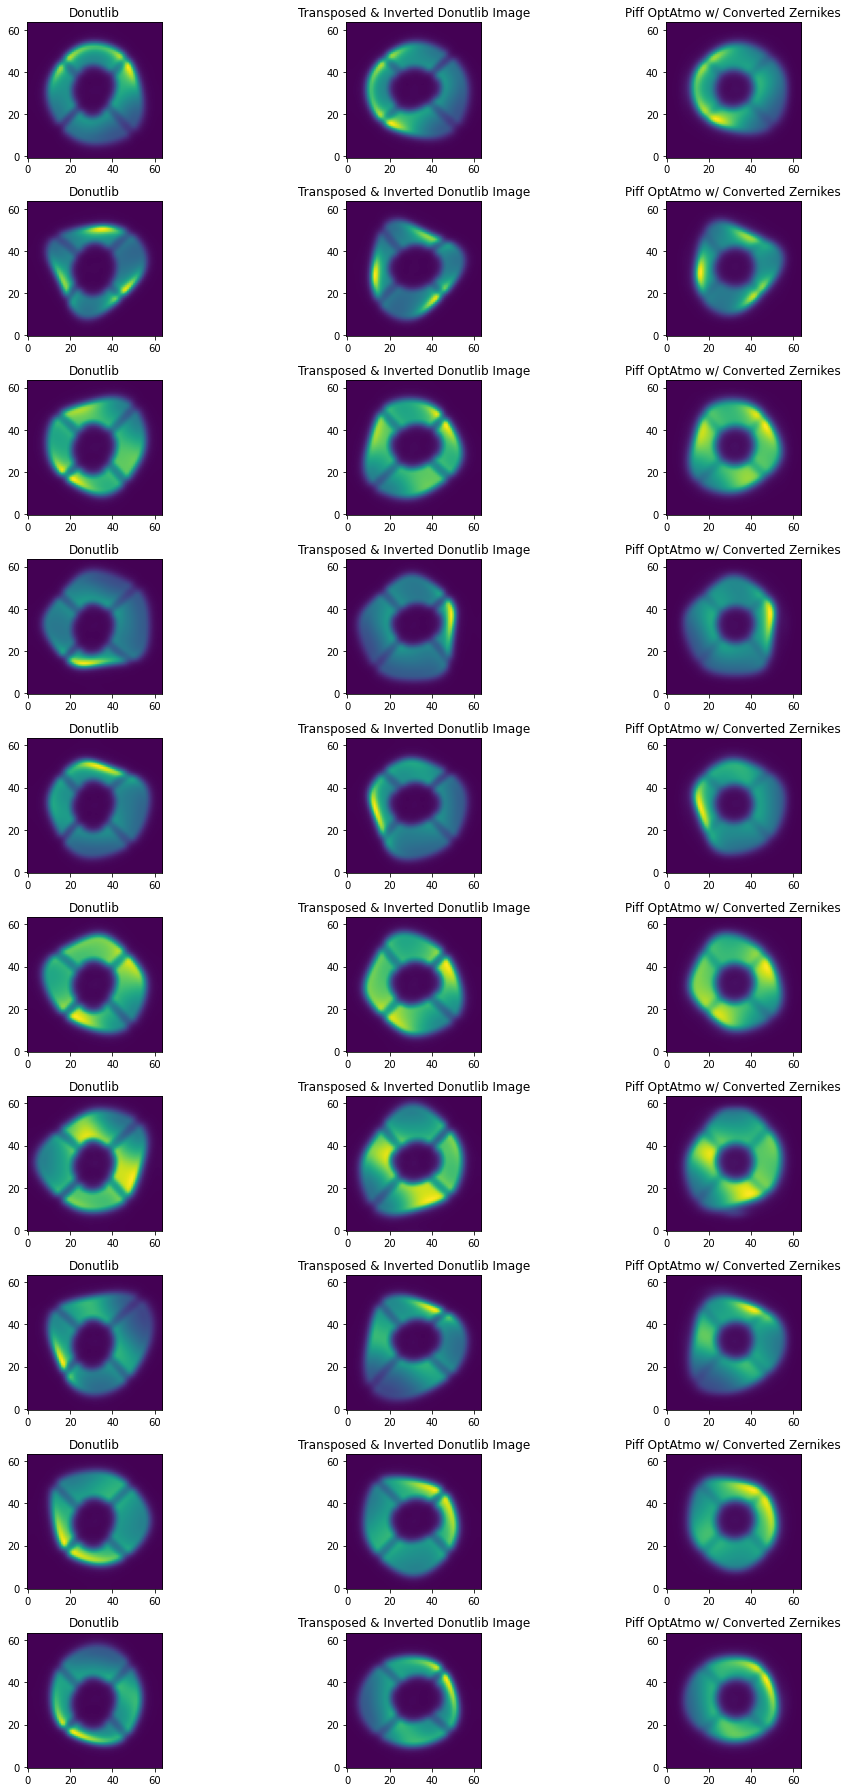

In [22]:
# compare donutlib vs. piff, 
# start with donutlib image which is in (x,y), 
# flip&transpose to make image look as it should in (u,v)
# then compare against Piff image with converted zernikes, also in (u,v)
# 
# the latter two should match!

r0 = 0.2 # Pretty good seeing, corresponds to 0.7 arcsec at 700nm
gd = galsim.GaussianDeviate(12345)
z4 = 12.0
fig, axes = plt.subplots(10, 3, figsize=(15, 25))
for i in range(10):
    # Add Gaussian-distributed aberrations
    zarray_ran = np.empty((17,), float)
    gd.generate(zarray_ran)
    zarray = [z4]+list(0.1*zarray_ran)
    
    print(', '.join(f'{q:.2f}' for q in zarray))
    #print(zarray)
    
    donut_image = donut_calc(zarray, r0)
    piff_image_zconvert = piff_calc(transform_zernike_new(zarray),r0)
    axes[i, 0].imshow(donut_image,origin='lower')
    axes[i, 1].imshow(np.transpose(np.flip(donut_image)),origin='lower') # should be correct
    axes[i, 2].imshow(piff_image_zconvert.array,origin='lower')

    axes[i, 0].set_title("Donutlib")
    axes[i, 1].set_title("Transposed & Inverted Donutlib Image")
    axes[i, 2].set_title("Piff OptAtmo w/ Converted Zernikes")

fig.tight_layout()
# fig.savefig("comparison.png")



# Conclusions

1. Donutlib to Piff/OptAtmo Zernike Conversion now understood
2. Need to revise OptAtmo code, or with -iFFT option in Galsim we'd need no conversion
3. Note that the Pupil plane - either Masks or Mirror figure need NO transformation from Donutlib for use in Galsim
